# Informazioni consegna
* Aggiungere i componenti del proprio gruppo in questo [form](https://forms.office.com/r/1WKBx4YgSH). 
* **I gruppi possono essere composti da massimo 3 persone. Nel caso si intenda fare il progetto da soli bisogna comunque aggiungere il proprio nome nel form.**
* Per la consegna è necessario caricare su Virtuale la relazione, il notebook Colab e le immagini generate.
* La consegna deve essere effettuata da un qualsiasi membro del gruppo e verrà automaticamente attribuita ai restanti componenti.
* Per i dettagli sulle tempistiche e le scadenze si faccia riferimento a Virtuale.

# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [336]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from scipy.optimize import minimize

# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512 $\times$ 512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


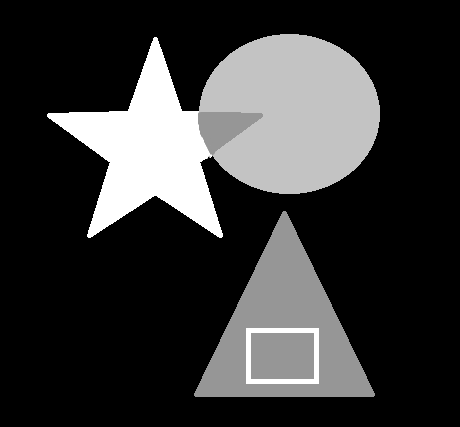


In [337]:
def normalize(image):
    return (image - np.min(image)) / np.ptp(image)

## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

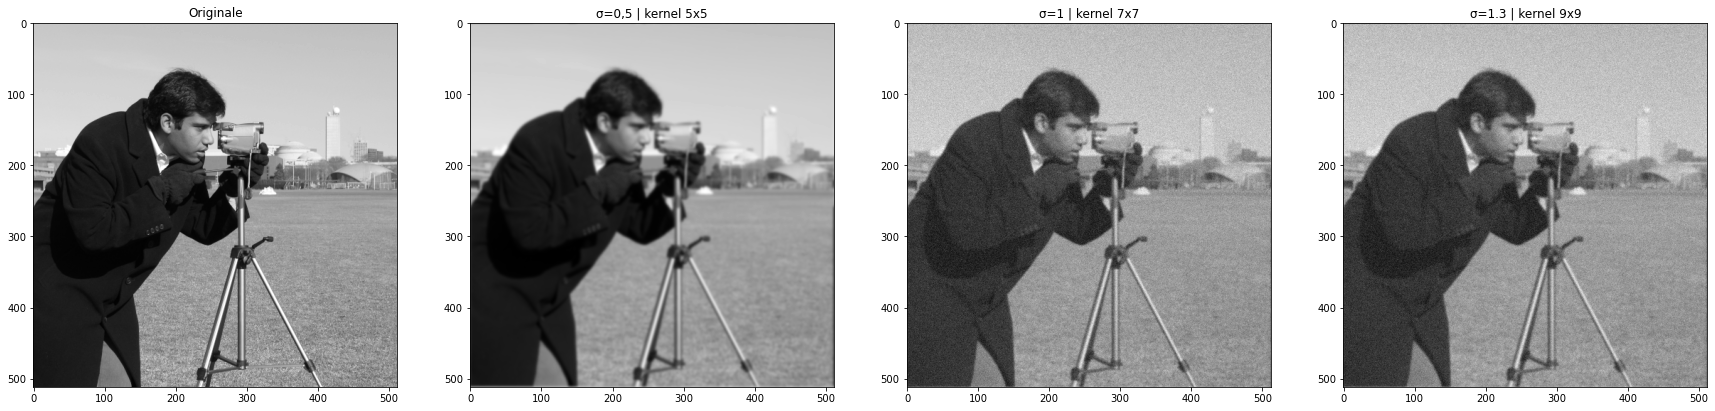

In [453]:
def gaussian_blur(image_size, kernel_len, sigma): 
    return psf_fft(gaussian_kernel(kernel_len, sigma), kernel_len, image_size)

real_image = data.camera().astype(np.float64) / 255.0
# real_image = plt.imread("./dataset/test.png").astype(np.float64)

# Filtro blur (A)
blur1 = gaussian_blur(real_image.shape, 24, 3)
blur2 = gaussian_blur(real_image.shape, 7, 1)
blur3 = gaussian_blur(real_image.shape, 9, 1.3)

# Filtro rumore (η)
dev = 0.05
noise = np.random.normal(size=real_image.shape) * dev

image1 = A(real_image, blur1) + noise
image2 = A(real_image, blur2) + noise
image3 = A(real_image, blur3) + noise

plt.figure(figsize=(30, 10))

ax = plt.subplot(1, 4, 1)
ax.imshow(real_image, cmap="gray")
plt.title("Originale")

ax = plt.subplot(1, 4, 2)
ax.imshow(image1, cmap="gray")
plt.title("σ=0,5 | kernel 5x5")

ax = plt.subplot(1, 4, 3)
ax.imshow(image2, cmap="gray")
plt.title("σ=1 | kernel 7x7")

ax = plt.subplot(1, 4, 4)
ax.imshow(image3, cmap="gray")
plt.title("σ=1.3 | kernel 9x9")

plt.show()


## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

In [339]:
def deblur_naive(image, blur, tol=None, max_iter=1000, callback=None):
    def f(x): 
        x = x.reshape(image.shape)
        return (1/2)*(np.linalg.norm(A(x, blur)-image)**2)
    def df(x):
        x = x.reshape(image.shape)
        return ( AT(A(x, blur), blur) - AT(image, blur) ).reshape(-1)

    out = minimize(
        fun = f, 
        x0=np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter}, 
        callback=callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }


## 3) Regolarizzazione
Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

In [340]:
def deblur_tikhonov_cg(image, blur, lamb, tol=None, max_iter=1000, callback=None):
    def f(x): 
        x = x.reshape(image.shape)
        return (1/2)*(np.linalg.norm(A(x, blur)-image)**2) + (lamb/2)*(np.linalg.norm(x)**2)
    def df(x):
        x = x.reshape(image.shape)
        return ( AT(A(x, blur), blur) - AT(image, blur) + (lamb*x) ).reshape(-1)

    out = minimize(
        fun = f, 
        x0 = np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter}, 
        callback = callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }


In [341]:
def next_step(f, x, grad):  # backtracking procedure for the choice of the steplength
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  p = -grad
  j = 0
  jmax = 10
  while ((f(x+alpha*p) > f(x) + c1 * alpha * grad.T @ p) and j < jmax):
    alpha = rho * alpha
    j += 1
  if (j > jmax):
    return -1
  else:
    return alpha

def gradiente(f, grad_f, x0, step, MAXITERATION, ABSOLUTE_STOP, callback):
  # initialize first values
  x_last = np.array(x0)
  
  k = 0
  while (np.linalg.norm(grad_f(x_last)) > ABSOLUTE_STOP and k < MAXITERATION ):
    k = k+1
    grad = grad_f(x_last)

    # backtracking step
    step = next_step(f, x_last, grad)
    
    if (step == -1):
      print('non convergente')
      return (k) # no convergence

    x_last= x_last - step*grad
    if callback is not None:
      callback(x_last)
 
  return (x_last, k)


def deblur_tikhonov_gd(image, blur, lamb, tol=1.e-5, max_iter=1000, callback=None):
  def f(x):
      x = x.reshape(image.shape)
      return (1/2)*(np.linalg.norm(A(x, blur) - image)**2) + (lamb/2)*(np.linalg.norm(x)**2)

  def df(x):
      x = x.reshape(image.shape)
      return ( AT(A(x, blur), blur) - AT(image, blur) + (lamb*x) ).reshape(-1)

  x0 = np.zeros(image.size)

  out, n_it = gradiente(
      f = f,
      grad_f = df,
      x0 = x0,
      step = next_step(f, x0, df(x0)),
      MAXITERATION = max_iter,
      ABSOLUTE_STOP = tol, 
      callback = callback
  )

  return {"image": out.reshape(image.shape), "n_it": n_it}


## 4) Variazione Totale (Facoltativo) 

Un'altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [342]:
eps = 1e-2

# Variazione totale
def totvar(x):
  # Calcola il gradiente di x
  dx, dy = np.gradient(x)
  n2 = np.square(dx) + np.square(dy)

  # Calcola la variazione totale di x
  tv = np.sqrt(n2 + eps**2).sum()
  return tv

# Gradiente della variazione totale
def grad_totvar(x):
  # Calcola il numeratore della frazione
  dx, dy = np.gradient(x)

  # Calcola il denominatore della frazione
  n2 = np.square(dx) + np.square(dy)
  den = np.sqrt(n2 + eps**2)

  # Calcola le due componenti di F dividendo il gradiente per il denominatore
  Fx = dx / den
  Fy = dy / den

  # Calcola la derivata orizzontale di Fx 
  dFdx = np.gradient(Fx, axis=0)
  
  # Calcola la derivata verticale di Fy
  dFdy = np.gradient(Fy, axis=1)

  # Calcola la divergenza 
  div = (dFdx + dFdy)

  # Restituisci il valore del gradiente della variazione totale
  return -div


In [343]:
def deblur_tv(image, blur, lamb, tol=None, max_iter=1000, callback=None):
    def f(x):
        x = x.reshape(image.shape)
        return (1 / 2) * (np.linalg.norm(A(x, blur)-image)**2) + (lamb*totvar(x))

    def df(x):
        x = x.reshape(image.shape)
        return ( (AT(A(x, blur), blur)-AT(image, blur)) + (lamb*grad_totvar(x)) ).reshape(-1)

    out = minimize(
        fun = f,
        x0=np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter},
        callback = callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }


<hr>

# Analisi dei metodi regolarizzati
Analisi delle prestazioni dei metodi regolarizzati al variare di $\lambda$. \
Viene eseguita una valutazione su un ampio intervallo e poi più nel dettaglio nell'intorno del punto migliore trovato.

In [440]:
# Plot del PSNR al variare di lambda
def plot_lambda_difference(x, y, title):
    max_i = y.index(max(y))  # Indice del punto migliore

    plt.figure(figsize=(10, 6), dpi=80)

    plt.grid()
    plt.title(title)
    plt.xlabel("λ")
    plt.ylabel("PSNR")

    plt.plot(x, y)

    plt.plot(x[max_i], y[max_i], "*") 
    plt.annotate(f" λ ≈ {round(x[max_i], 5)}", (x[max_i], y[max_i]))
    
    plt.show()


curr_image = image1
curr_blur = blur1


## Tikhonov con gradiente coniugato

In [441]:
x_tikhonov1 = np.arange(0.01, 1, 0.01)
y_tikhonov1 = []

for lamb in x_tikhonov1:
    print(lamb, end=" ")
    out = deblur_tikhonov_cg(curr_image, curr_blur, lamb, tol=1e-5)
    y_tikhonov1 = y_tikhonov1 + [metrics.peak_signal_noise_ratio(real_image, out["image"])]


0.01 0.02 0.03 0.04 0.05 0.060000000000000005 0.06999999999999999 0.08 0.09 0.09999999999999999 0.11 0.12 0.13 0.14 0.15000000000000002 0.16 0.17 0.18000000000000002 0.19 0.2 0.21000000000000002 0.22 0.23 0.24000000000000002 0.25 0.26 0.27 0.28 0.29000000000000004 0.3 0.31 0.32 0.33 0.34 0.35000000000000003 0.36000000000000004 0.37 0.38 0.39 0.4 0.41000000000000003 0.42000000000000004 0.43 0.44 0.45 0.46 0.47000000000000003 0.48000000000000004 0.49 0.5 0.51 0.52 0.53 0.54 0.55 0.56 0.5700000000000001 0.5800000000000001 0.59 0.6 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.6900000000000001 0.7000000000000001 0.7100000000000001 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8 0.81 0.8200000000000001 0.8300000000000001 0.8400000000000001 0.85 0.86 0.87 0.88 0.89 0.9 0.91 0.92 0.93 0.9400000000000001 0.9500000000000001 0.9600000000000001 0.97 0.98 0.99 

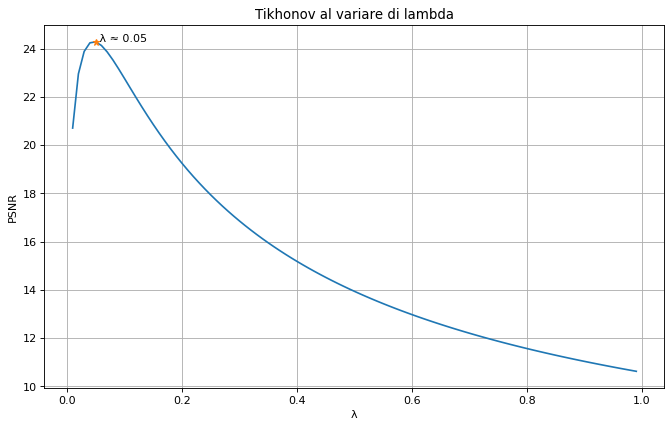

lambda = 0.05 | PSNR = 24.27975982153508


In [442]:
plot_lambda_difference(x_tikhonov1, y_tikhonov1, "Tikhonov al variare di lambda")

max_i = y_tikhonov1.index(max(y_tikhonov1))  # Indice del punto migliore
print(f"lambda = {x_tikhonov1[max_i]} | PSNR = {y_tikhonov1[max_i]}")
tikhonov_best = x_tikhonov1[max_i]

## Variazione totale

In [352]:
x_tv1 = np.arange(0.01, 1, 0.01)
y_tv1 = []

for lamb in x_tv1:
    print(lamb, end=" ")
    out = deblur_tv(curr_image, curr_blur, lamb)
    y_tv1 = y_tv1 + [metrics.peak_signal_noise_ratio(real_image, out["image"])]


0.01 0.02 0.03 0.04 0.05 0.060000000000000005 0.06999999999999999 0.08 0.09 0.09999999999999999 0.11 0.12 0.13 0.14 0.15000000000000002 0.16 0.17 0.18000000000000002 0.19 0.2 0.21000000000000002 0.22 0.23 0.24000000000000002 0.25 0.26 0.27 0.28 0.29000000000000004 0.3 0.31 0.32 0.33 0.34 0.35000000000000003 0.36000000000000004 0.37 0.38 0.39 0.4 0.41000000000000003 0.42000000000000004 0.43 0.44 0.45 0.46 0.47000000000000003 0.48000000000000004 0.49 0.5 0.51 0.52 0.53 0.54 0.55 0.56 0.5700000000000001 0.5800000000000001 0.59 0.6 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.6900000000000001 0.7000000000000001 0.7100000000000001 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8 0.81 0.8200000000000001 0.8300000000000001 0.8400000000000001 0.85 0.86 0.87 0.88 0.89 0.9 0.91 0.92 0.93 0.9400000000000001 0.9500000000000001 0.9600000000000001 0.97 0.98 0.99 

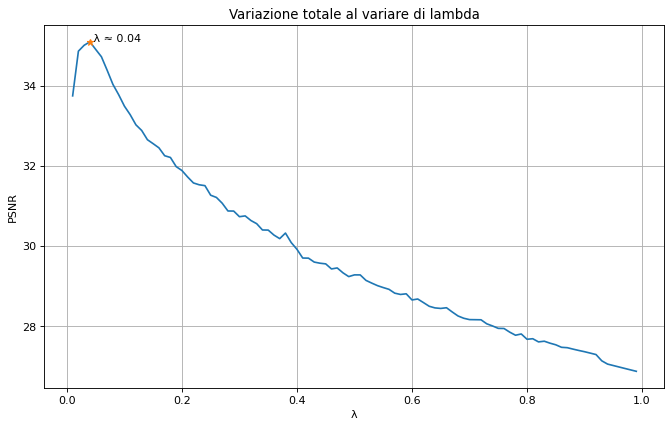

lambda = 0.04 | PSNR = 35.094406669814376


In [353]:
plot_lambda_difference(x_tv1, y_tv1, "Variazione totale al variare di lambda")

max_i = y_tv1.index(max(y_tv1))  # Indice del punto migliore
print(f"lambda = {x_tv1[max_i]} | PSNR = {y_tv1[max_i]}")
tv_best = x_tv1[max_i]


# Esecuzione preliminare
Esecuzione dei metodi applicati ad un'immagine per una prima valutazione delle prestazioni dei metodi

In [354]:
curr_image = image1
curr_blur = blur1
lambda_tikhonov = tikhonov_best
lambda_tv = round(tv_best, 2)
# lambda_tikhonov = 0.19
# lambda_tv = 0.07

out_naive = deblur_naive(curr_image, curr_blur, max_iter=200)
print("Done - Naive")
out_tikhonov_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov)
print("Done - Tikhonov CG")
out_tikhonov_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov)
print("Done - Tikhonov GD")
out_tv = deblur_tv(curr_image, curr_blur, lambda_tv)
print("Done - TV")


Done - Naive
Done - Tikhonov CG
Done - Tikhonov GD
Done - TV


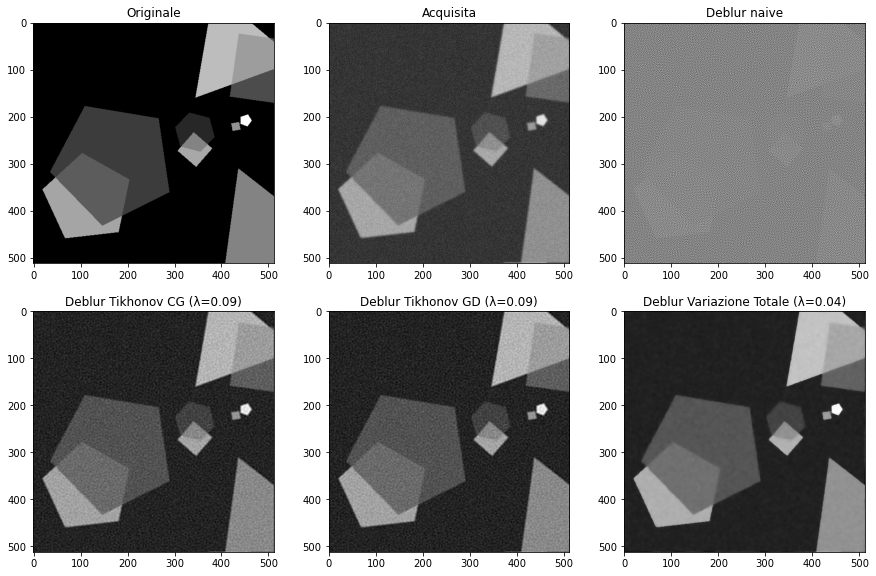

MSE originale/acquisita             0.0032035677857523617
MSE originale/naive                 5.719386270374898
MSE originale/Tikhonov1             0.0015527654741680059
MSE originale/Tikhonov2             0.0015527355683298697
MSE originale/Variazione totale     0.0003094278024748073

PSNR originale/acquisita            24.943660821398144
PSNR originale/naive                -7.5734942849760305
PSNR originale/Tikhonov1            28.08894134075784
PSNR originale/Tikhonov2            28.089024985492152
PSNR originale/Variazione totale    35.094406669814376

Ierazioni naive                     200
Ierazioni Tikhonov CG               18
Ierazioni Tikhonov GD               99
Ierazioni Variazione totale         29


In [370]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01)

ax[0, 0].imshow(real_image, cmap="gray")
ax[0, 0].set_title("Originale")

ax[0, 1].imshow(curr_image, cmap="gray")
ax[0, 1].set_title("Acquisita")

ax[0, 2].imshow(out_naive["image"], cmap="gray")
ax[0, 2].set_title(f"Deblur naive")

ax[1, 0].imshow(out_tikhonov_cg["image"], cmap="gray")
ax[1, 0].set_title(f"Deblur Tikhonov CG (λ={lambda_tikhonov})")

ax[1, 1].imshow(out_tikhonov_gd["image"], cmap="gray")
ax[1, 1].set_title(f"Deblur Tikhonov GD (λ={lambda_tikhonov})")

ax[1, 2].imshow(out_tv["image"], cmap="gray")
ax[1, 2].set_title(f"Deblur Variazione Totale (λ={lambda_tv})")

plt.show()

print(f"{'MSE originale/acquisita':<35} {metrics.mean_squared_error(real_image, curr_image)}")
print(f"{'MSE originale/naive':<35} {metrics.mean_squared_error(real_image, out_naive['image'])}")
print(f"{'MSE originale/Tikhonov1':<35} {metrics.mean_squared_error(real_image, out_tikhonov_cg['image'])}")
print(f"{'MSE originale/Tikhonov2':<35} {metrics.mean_squared_error(real_image, out_tikhonov_gd['image'])}")
print(f"{'MSE originale/Variazione totale':<35} {metrics.mean_squared_error(real_image, out_tv['image'])}")
print()
print(f"{'PSNR originale/acquisita':<35} {metrics.peak_signal_noise_ratio(real_image, curr_image)}")
print(f"{'PSNR originale/naive':<35} {metrics.peak_signal_noise_ratio(real_image, out_naive['image'])}")
print(f"{'PSNR originale/Tikhonov1':<35} {metrics.peak_signal_noise_ratio(real_image, out_tikhonov_cg['image'])}")
print(f"{'PSNR originale/Tikhonov2':<35} {metrics.peak_signal_noise_ratio(real_image, out_tikhonov_gd['image'])}")
print(f"{'PSNR originale/Variazione totale':<35} {metrics.peak_signal_noise_ratio(real_image, out_tv['image'])}")
print()
print(f"{'Ierazioni naive':<35} {out_naive['n_it']}")
print(f"{'Ierazioni Tikhonov CG':<35} {out_tikhonov_cg['n_it']}")
print(f"{'Ierazioni Tikhonov GD':<35} {out_tikhonov_gd['n_it']}")
print(f"{'Ierazioni Variazione totale':<35} {out_tv['n_it']}")


# Confronto prestazioni Tikhonov con Gradiente Coniugato e Metodo del Gradiente

In [457]:
curr_image = image1
curr_blur = blur1
lambda_tikhonov = tikhonov_best
lambda_tv = round(tv_best, 2)


Text(0.5, 1.0, 'Deblur Tikhonov GD AAA')

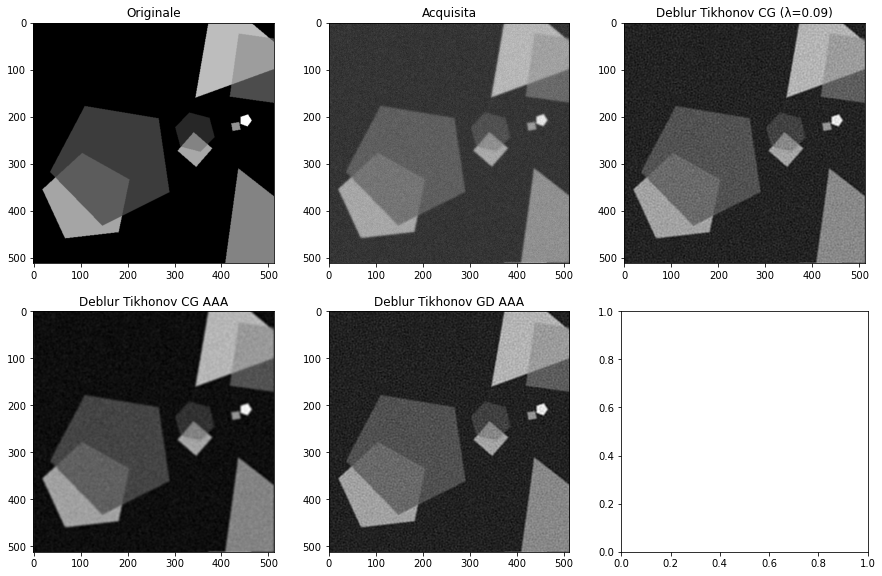

In [413]:
out_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov, tol=1e-1)
out_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov, tol=1e-1)

fig, ax = plt.subplots(2, 3, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01)
ax[0, 0].imshow(real_image, cmap="gray")
ax[0, 0].set_title("Originale")

ax[0, 1].imshow(curr_image, cmap="gray")
ax[0, 1].set_title("Acquisita")

ax[0, 2].imshow(out_tikhonov_cg["image"], cmap="gray")
ax[0, 2].set_title(f"Deblur Tikhonov CG (λ={lambda_tikhonov})")

ax[1, 0].imshow(out_cg["image"], cmap="gray")
ax[1, 0].set_title(f"Deblur Tikhonov CG AAA")

ax[1, 1].imshow(out_gd["image"], cmap="gray")
ax[1, 1].set_title(f"Deblur Tikhonov GD AAA")


In [461]:
tols = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
n_it_cg = []
n_it_gd = []
psnr_cg = []
psnr_gd = []

for tol in tols:
    print(tol)
    out_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov, tol=tol)
    n_it_cg = n_it_cg + [out_cg["n_it"]]
    psnr_cg = psnr_cg + [metrics.peak_signal_noise_ratio(real_image, out_cg["image"])]
    
    out_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov, tol=tol)
    n_it_gd = n_it_gd + [out_gd["n_it"]]
    psnr_gd = psnr_gd + [metrics.peak_signal_noise_ratio(real_image, out_gd["image"])]


0.1
0.01
0.001
0.0001
1e-05


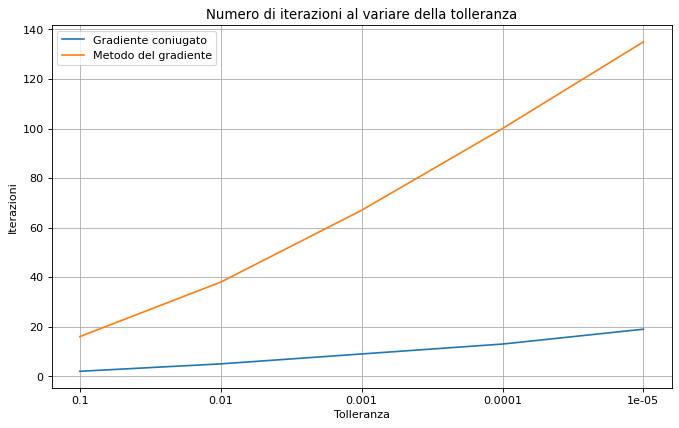

In [462]:
plt.figure(figsize=(10, 6), dpi=80)

plt.grid()
plt.title("Numero di iterazioni al variare della tolleranza")
plt.xlabel("Tolleranza")
plt.ylabel("Iterazioni")

tols_s = [str(tol) for tol in tols]
plt.plot(tols_s, n_it_cg, label="Gradiente coniugato")
plt.plot(tols_s, n_it_gd, label="Metodo del gradiente")
plt.legend()

plt.show()


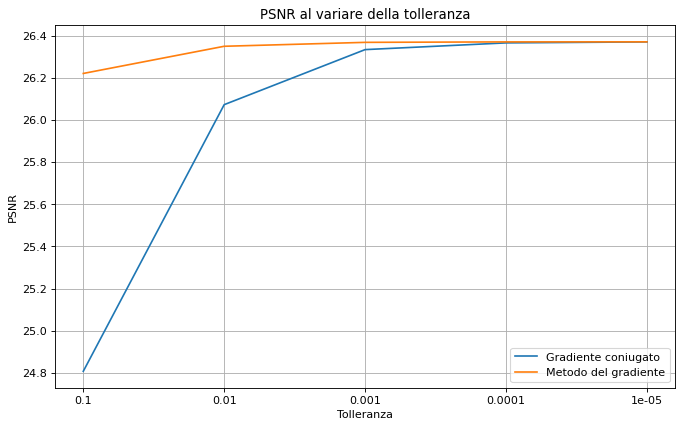

In [463]:
plt.figure(figsize=(10, 6), dpi=80)

plt.grid()
plt.title("PSNR al variare della tolleranza")
plt.xlabel("Tolleranza")
plt.ylabel("PSNR")

tols_s = [str(tol) for tol in tols]
plt.plot(tols_s, psnr_cg, label="Gradiente coniugato")
plt.plot(tols_s, psnr_gd, label="Metodo del gradiente")
plt.legend()

plt.show()


In [459]:
xk_cg = []
xk_gd = []

def append_cg(xk):
    global xk_cg
    xk_cg = xk_cg + [xk]

def append_gd(xk):
    global xk_gd
    xk_gd = xk_gd + [xk]

out_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov, callback=append_cg)

out_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov, callback=append_gd)


In [ ]:
print(xk_cg)

18


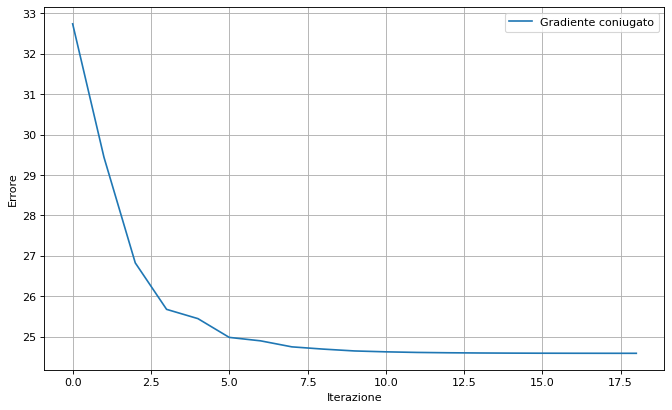

In [460]:
plt.figure(figsize=(10, 6), dpi=80)

plt.grid()
plt.title("")
plt.xlabel("Iterazione")
plt.ylabel("Errore")

i_min = [np.linalg.norm(xk.reshape(real_image.shape) - real_image) for xk in xk_cg].index(min([np.linalg.norm(xk.reshape(real_image.shape) - real_image) for xk in xk_cg]))
print(i_min)
plt.plot([i for i in range(len(xk_cg))], [np.linalg.norm(xk.reshape(real_image.shape) - real_image) for xk in xk_cg], label="Gradiente coniugato")
# plt.plot([i for i in range(len(xk_gd))], [np.linalg.norm(xk.reshape(real_image.shape) - real_image) for xk in xk_gd], label="Metodo del gradiente")
plt.legend()

plt.show()


In [452]:
# plt.imshow(xk_cg[0].reshape(curr_image.shape), cmap="gray")
# plt.show()
# plt.imshow(xk_cg[3].reshape(curr_image.shape), cmap="gray")
# plt.show()
# plt.imshow(xk_cg[-1].reshape(curr_image.shape), cmap="gray")
# plt.show()

print(metrics.peak_signal_noise_ratio(real_image, xk_cg[0].reshape(curr_image.shape)))
print(metrics.peak_signal_noise_ratio(real_image, xk_cg[3].reshape(curr_image.shape)))
print(metrics.peak_signal_noise_ratio(real_image, xk_cg[-1].reshape(curr_image.shape)))


22.424180804156858
23.338672720773598
23.1565933842044


In [ ]:

def a(xk):
    xk = xk.reshape(curr_image.shape)
    print(metrics.peak_signal_noise_ratio(real_image, xk))
    # plt.imshow(xk, cmap="gray")
    # plt.show()


out_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov, callback=a)


In [ ]:

"""

TODO
X Graficare gli errori al variare di lambda
- Confronto CG, GD
- Grafico a barre su più esecuzioni (max, mean, min)
- Graficare l'errore progressivo
- Semiconvergenza

"""


"\n\nTODO\nX Graficare gli errori al variare di lambda\n- Confronto CG, GD\n- Grafico a barre su più esecuzioni (max, mean, min)\n- Graficare l'errore progressivo\n\n"

# Relazione

1.   Riportare e commentare i risultati ottenuti nei punti 2. 3. (e 4.) su un immagine del set creato e su altre due immagini in bianco e nero  (fotografiche/mediche/astronomiche)
2.   Riportare delle tabelle con le misure di PSNR e MSE ottenute al variare dei parametri (dimensione kernel, valore di sigma, la deviazione standard del rumore, il parametro di regolarizzazione). 
3. Calcolare sull’intero set di immagini medie e deviazione standard delle metriche per alcuni valori fissati dei parametri.  
4. Analizzare su 2 esecuzioni le proprietà dei metodi numerici utilizzati (gradiente coniugato e gradiente) in termini di numero di iterazioni, andamento dell’errore, della funzione obiettivo, norma del gradiente. 

